#### Objective

> Decorrelation is a general term for any process that is used to reduce autocorrelation within a signal, or cross-correlation within a set of signals, while preserving other aspects of the signal.

> The objective of the current work is to  provide decorrelated displacement values (i.e. no longer dependent on temperature and sunlight) at the same time steps. To this end, we will fit a regression model and evaluate its performance before and after applying decorrelation. While there are various models for decorrelation including Principal component analysis (PCA), Wavelet-Based Transform, eetcetera, the current study will use a denoising approach.

#### Import Packages

In [19]:
%%time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

Wall time: 0 ns


### Import Data

In [20]:
%%time
df = pd.read_csv('data/data.txt')

#Overview of the data
df.head(10)

Wall time: 14 ms


,TIMESTAMP,deplacement,ensoleillement,temperature
0,2020-03-14 00:01:22,1.3,0.0,8.381906
1,2020-03-14 00:18:05,0.5,0.0,8.388235
2,2020-03-14 00:35:17,1.8,0.0,8.397227
3,2020-03-14 00:52:39,NAN,0.0,8.411952
4,2020-03-14 01:09:27,1.7,0.0,8.426197
5,2020-03-14 01:26:24,1.7,0.0,8.440569
6,2020-03-14 01:43:18,1.8,0.0,8.463093
7,2020-03-14 02:00:09,1.7,0.0,8.487763
8,2020-03-14 02:16:58,1.9,0.0,8.512384
9,2020-03-14 02:33:50,1.7,0.0,8.503086


In [21]:
#Replace NAN with empty entry
df['deplacement'] = df['deplacement'].str.replace('NAN','')
#Replace mtpy rows with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)
#Overview of the data
df.head(10)

,TIMESTAMP,deplacement,ensoleillement,temperature
0,2020-03-14 00:01:22,1.3,0.0,8.381906
1,2020-03-14 00:18:05,0.5,0.0,8.388235
2,2020-03-14 00:35:17,1.8,0.0,8.397227
3,2020-03-14 00:52:39,NaN,0.0,8.411952
4,2020-03-14 01:09:27,1.7,0.0,8.426197
5,2020-03-14 01:26:24,1.7,0.0,8.440569
6,2020-03-14 01:43:18,1.8,0.0,8.463093
7,2020-03-14 02:00:09,1.7,0.0,8.487763
8,2020-03-14 02:16:58,1.9,0.0,8.512384
9,2020-03-14 02:33:50,1.7,0.0,8.503086


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1848 entries, 0 to 1847
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TIMESTAMP       1848 non-null   object 
 1   deplacement     1761 non-null   object 
 2   ensoleillement  1848 non-null   float64
 3   temperature     1848 non-null   float64
dtypes: float64(2), object(2)
memory usage: 57.9+ KB


In [23]:
#Convert deplacement variable from object to numeric

df['deplacement'] = pd.to_numeric(df['deplacement'])

#covert timestamp to datetime
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1848 entries, 0 to 1847
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TIMESTAMP       1848 non-null   datetime64[ns]
 1   deplacement     1761 non-null   float64       
 2   ensoleillement  1848 non-null   float64       
 3   temperature     1848 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 57.9 KB


#### Visual exploration of the attributes

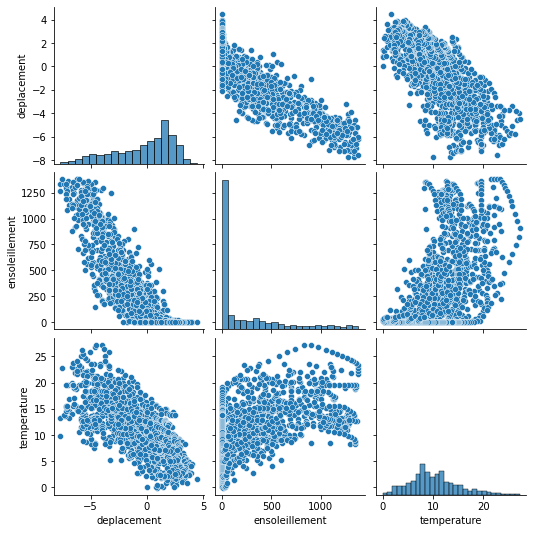

In [24]:
sns.pairplot(df)
# to show
plt.show()

> From the figure above, it is noted that an increase in either ensoleillement or temperature corresponds to an decrease in deplacement indicating that there is a negative association between displacement, temperature and insolation measurements. The following plot shows the correlation scores between the three attributes.

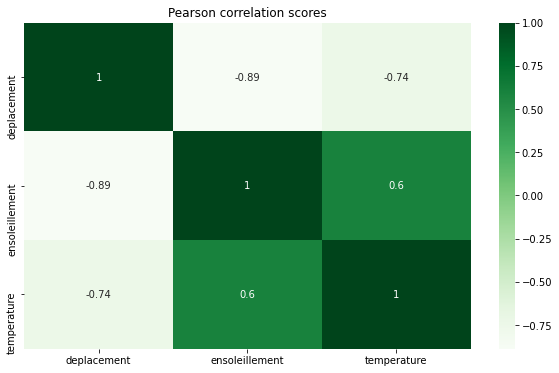

In [25]:
corr = df.corr(method = 'pearson')
plt.figure(figsize=(10,6))
sns.heatmap(corr, cmap="Greens",annot=True)
plt.title("Pearson correlation scores")
plt.show()

#### Fill missing

In [26]:
#replace missing with median

df = df.fillna(df.median(numeric_only=True))

#### Fit Linear Regression Model using the correlated data

In [27]:
X = df[['ensoleillement', 'temperature']]

y = df['deplacement']

# Fit the model
model = sm.OLS(y, X).fit()

#Check model performance
from statsmodels.tools.eval_measures import rmse


#generate predictions
ypred = model.predict(X)

# calc rmse
rmse_orig = round(rmse(y, ypred), 4)
rmse_orig

1.5491

### Decorrelation

> Generally, decorrelation is defined as the process that is used to reduce autocorrelation within a signal, or cross-correlation within a given set of signals, while retaining alll other aspects of the signal (Xing, Kaaniche, Pesquet-Popescu, & Dufaux, 2016).

> The current study uses whitening to reduce correlation between the attributes in the dataset. Essentially, whitening, involves imposing an identity covariance matrix to a zero-centered dataset. One of the main advantages of whitening is the decorrelation of the dataset, which allows an easier separation of the components (Bonaccorso, Fandango, & Shanmugamani, 2018). Therefore, to remove the correlation between the attributes, two main steps are adopted i.e., zero-centering and whitening. Each of these methods accept a matrix X having shape (NSamples × n).Besides, the whiten() function takes an additional parameter *correct*, which enables the application of scaling correction (the default value is True).


*See https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781789957211/1/ch01lvl1sec9/models-and-data*


##### Denoising

So the data can be decorrelated through projecting the data using the eigenvectors. This will have the effect to apply the rotation needed and iin turn remove correlations between the dimensions. The followinf steps are adopted during denoising:

1. Calculate the covariance matrix
2. Calculate the eigenvectors of the covariance matrix
3. Apply the matrix of eigenvectors to the data — this will apply the rotation

In [28]:
#centering the data around the mean
def center(X):
    newX = X - np.mean(X, axis = 0)
    return newX

#decorrelateing
def decorrelate(X, correct=True):
    Xc = center(X)
    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    _, L, V = np.linalg.svd(Xc)
    W = np.dot(V.T, np.diag(1.0 / L))
    # Apply the eigenvectors to X
    if correct:
        decorrelated = np.dot(Xc, W) * np.sqrt(X.shape[0])
    else:
        decorrelated = 1.0
    return decorrelated

In [29]:
#decorrelated data
#drop datetime
df1 = df.drop('TIMESTAMP', axis = 1)

df2 = pd.DataFrame()

df2['TIMESTAMP'] = df['TIMESTAMP']

df2[df1.columns]= decorrelate(df1, correct = 1) #1 == True

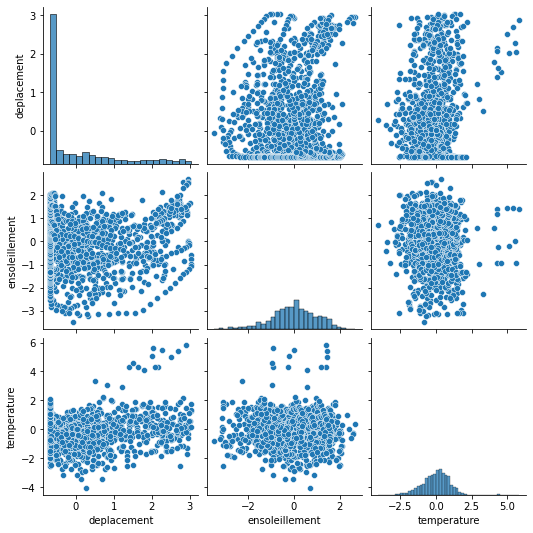

Wall time: 6.12 s


In [30]:
%%time
sns.pairplot(df2)
# to show
plt.show()

> From the plot above, there is no apparent relationship between deplacement, temperature, and ensoillement indicating that the correlation has been removed.

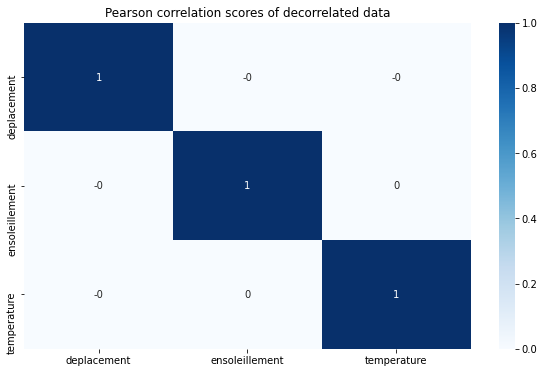

In [31]:
#round off to generate the correlation scores
corr = round(df2.corr(method = 'pearson'), 7)
plt.figure(figsize=(10,6))
sns.heatmap(corr, cmap="Blues",annot=True)
plt.title("Pearson correlation scores of decorrelated data")
plt.show()

#### Linear Regression

> We will fit another regression model and evaluate its performance.

In [32]:
X = df2[['ensoleillement', 'temperature']]

y = df2['deplacement']

# Fit the model
model = sm.OLS(y, X).fit()

#Check model performance
from statsmodels.tools.eval_measures import rmse


#generate predictions
ypred = model.predict(X)

# calc rmse
rmse_decor = rmse(y, ypred)
rmse_decor

1.0

#### Compare performance of the linear regression models

In [33]:
model = ['Original attributes', 'Decorrelated attributes']

rmse = [rmse_orig, rmse_decor]

perf = pd.DataFrame()

perf['Model'] = model

perf['RMSE'] = rmse

perf

,Model,RMSE
0,Original attributes,1.5491
1,Decorrelated attributes,1.0000


> As noted from above, the linear regression model achieves a smaller RMSE indicating the decorrelation improved the performance of the regression model.

##### Save the decorrelated deplacement values

In [34]:
df2.to_csv('decorrelated_data.txt', index = False)

### References 

1. Bonaccorso, G., Fandango, A., & Shanmugamani, R. (2018). Python: Advanced Guide to Artificial Intelligence. Packt. From https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781789957211/1/ch01lvl1sec9/models-and-data


2. Xing, Y., Kaaniche, M., Pesquet-Popescu, B., & Dufaux, F. (2016). Chapter 3 - Basic Compression Tools. In Y. Xing, M. Kaaniche, B. Pesquet-Popescu, & F. Dufaux (Eds.), Digital Holographic Data Representation and Compression (pp. 19-24). Academic Press.

